In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, IterableDataset, Dataset
from tqdm import tqdm
import utils
import matplotlib.pyplot as plt
from torchmetrics.image.fid import FrechetInceptionDistance

/nethome/zwang910/file_storage/miniconda3/envs/dl/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# test loader
cl_train_loaders, cl_test_loaders, train_loader, test_loader = utils.get_cl_dataset('mnist', batch_size=128, normalize=False)

Building DataLoaders for each class in train dataset...


100%|██████████| 60000/60000 [00:04<00:00, 13399.09it/s]


Building DataLoaders for each class in MNIST test dataset...


100%|██████████| 10000/10000 [00:00<00:00, 13770.17it/s]


In [4]:
def test_class_loaders(class_loaders):
    # 1) Check we have exactly 10 loaders for digits 0–9
    assert len(class_loaders) == 10, f"Expected 10 loaders, got {len(class_loaders)}"
    print("✅ Correct number of loaders: 10")

    # 2) Check each loader only contains its corresponding class
    for class_id, loader in sorted(class_loaders.items()):
        images, labels = next(iter(loader))
        unique_labels = set(labels.tolist())
        assert unique_labels == {class_id}, (
            f"Loader {class_id} yielded labels {unique_labels}, expected only {class_id}"
        )
    print("✅ Each loader yields only its corresponding class labels")

def visualize_class_loaders(class_loaders, samples_per_class=4):
    fig, axes = plt.subplots(
        nrows=10, ncols=samples_per_class, figsize=(samples_per_class * 2, 10 * 2)
    )
    fig.suptitle("First 4 samples from each class-specific loader", fontsize=16)
    
    for row, (class_id, loader) in enumerate(sorted(class_loaders.items())):
        images, labels = next(iter(loader))
        for col in range(samples_per_class):
            img = images[col].squeeze().cpu().numpy()
            ax = axes[row, col]
            ax.imshow(img, cmap='gray')
            ax.set_title(f"Digit {labels[col].item()}")
            ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [5]:
# 2) Run the loader tests
test_class_loaders(cl_train_loaders)

# 3) Visualize 4 samples per class
# visualize_class_loaders(cl_train_loaders)

✅ Correct number of loaders: 10
✅ Each loader yields only its corresponding class labels


In [9]:
# train a classifier from the held-out loaders
class clf(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # conv1: 1×28×28 → 32×28×28 → 32×14×14
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # conv2: 32×14×14 → 64×14×14 → 64×7×7
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # conv3: 64×7×7 → 128×7×7 → 128×3×3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),               # → 128*3*3 = 1152 features
            nn.Linear(128*3*3, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
lr = 1e-3
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

clf = clf().to(device)
optimizer = torch.optim.Adam(clf.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, epochs+1):
    clf.train()
    running_loss = 0.0
    for imgs, labels in tqdm(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = clf(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")

100%|██████████| 157/157 [00:01<00:00, 104.18it/s]


Epoch 1/5, Loss: 0.1193


100%|██████████| 157/157 [00:01<00:00, 141.36it/s]


Epoch 2/5, Loss: 0.0283


100%|██████████| 157/157 [00:01<00:00, 143.58it/s]


Epoch 3/5, Loss: 0.0171


100%|██████████| 157/157 [00:01<00:00, 144.58it/s]


Epoch 4/5, Loss: 0.0129


100%|██████████| 157/157 [00:01<00:00, 142.42it/s]

Epoch 5/5, Loss: 0.0114


In [4]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

Class 0 loader: 47 batches


100%|██████████| 47/47 [00:00<00:00, 56.96it/s]


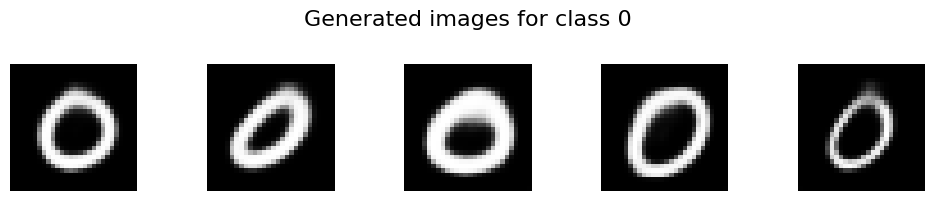

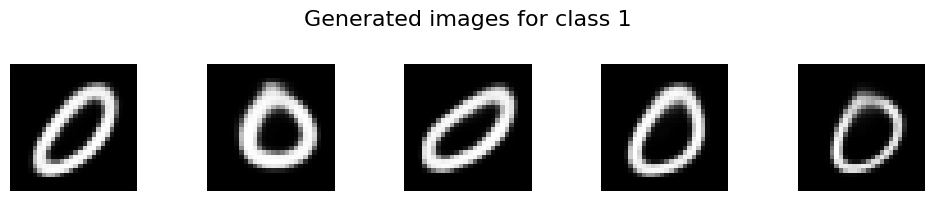

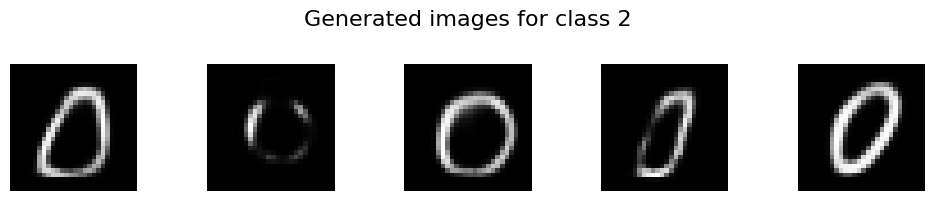

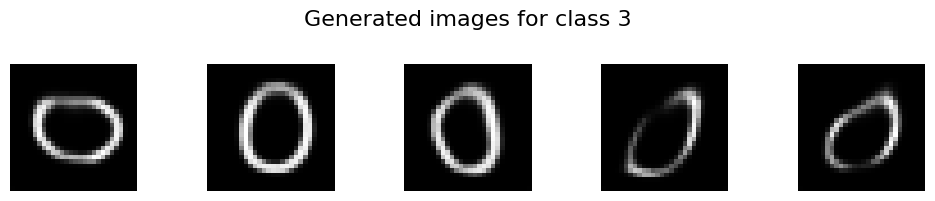

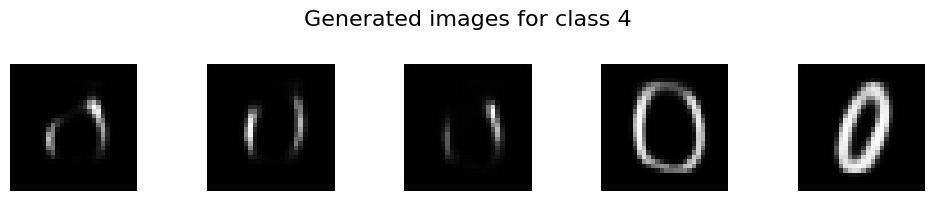

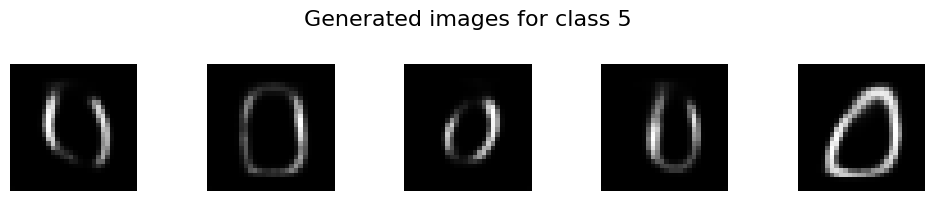

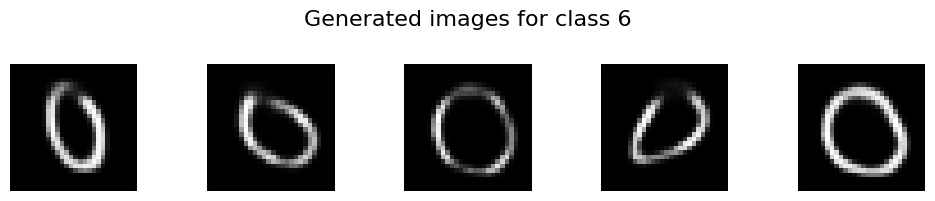

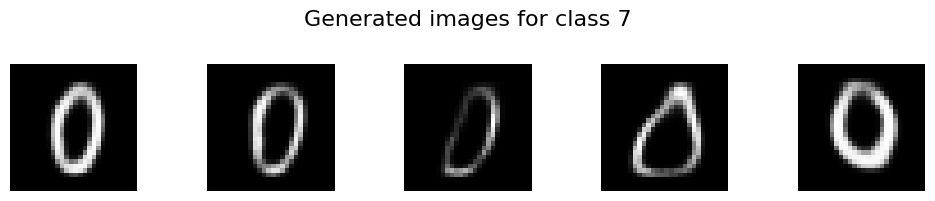

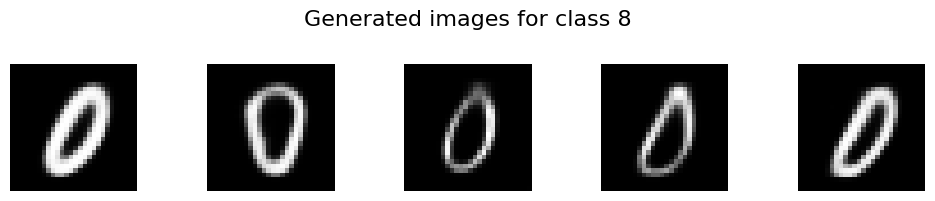

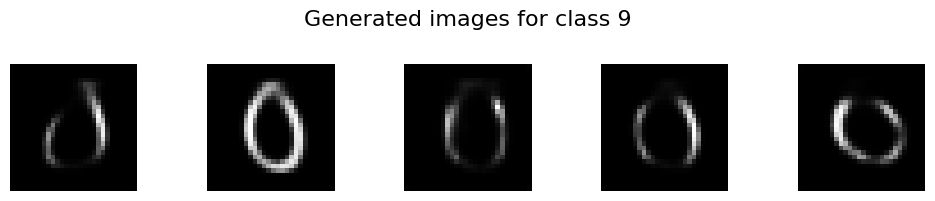

Class 1 loader: 53 batches


100%|██████████| 53/53 [00:01<00:00, 41.54it/s]


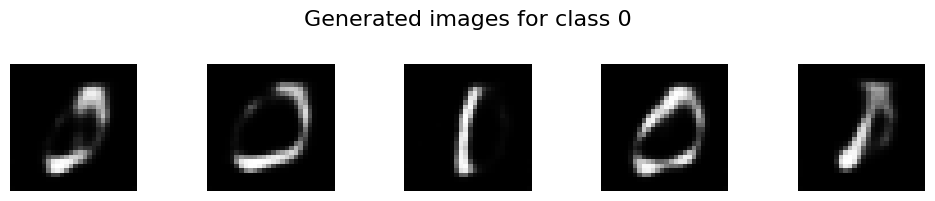

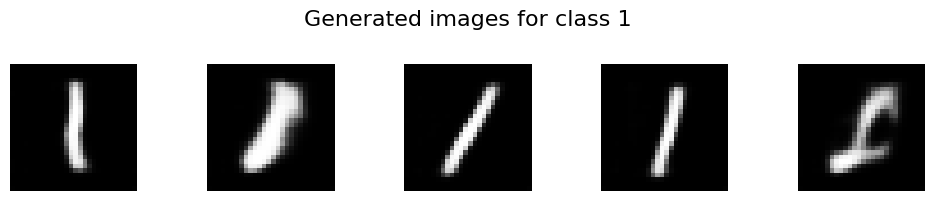

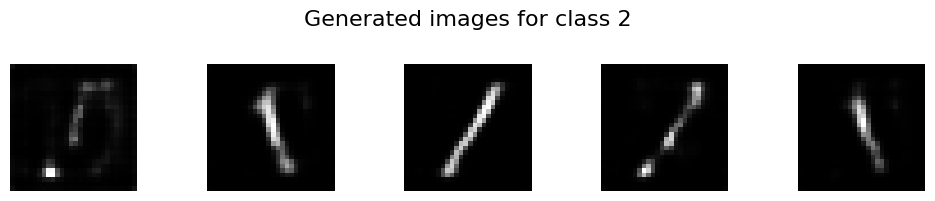

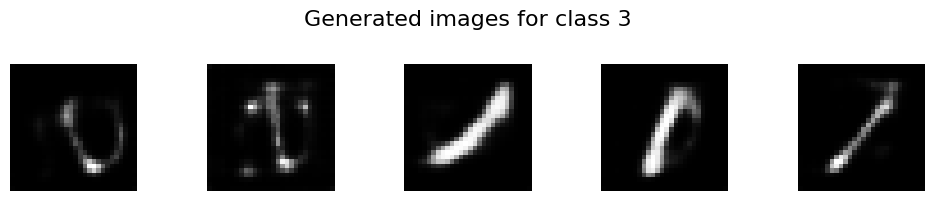

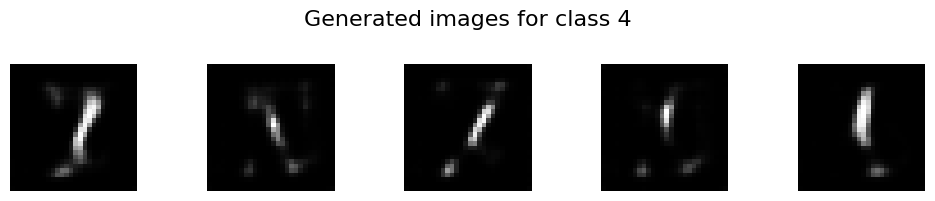

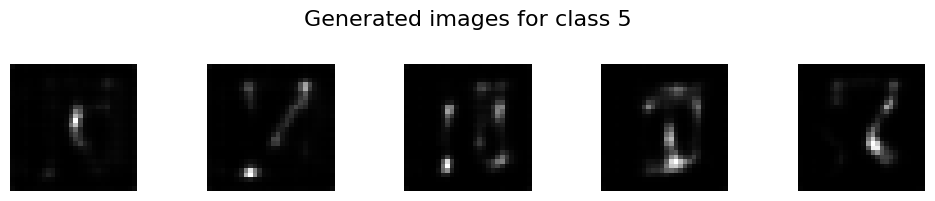

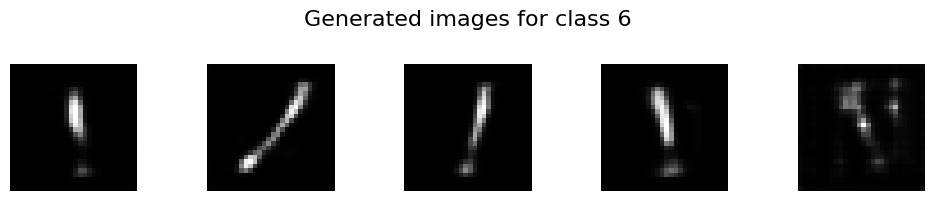

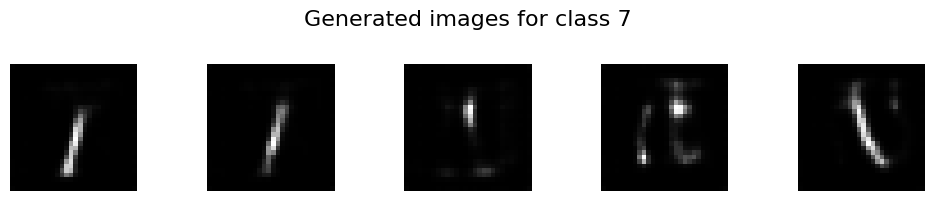

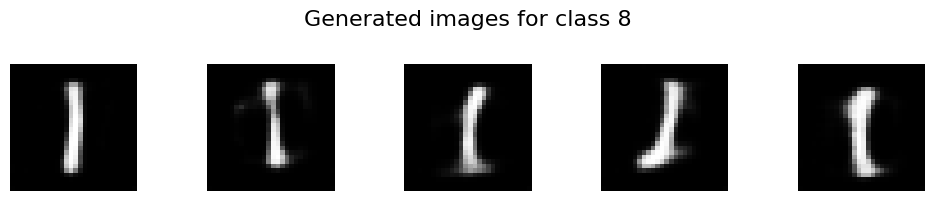

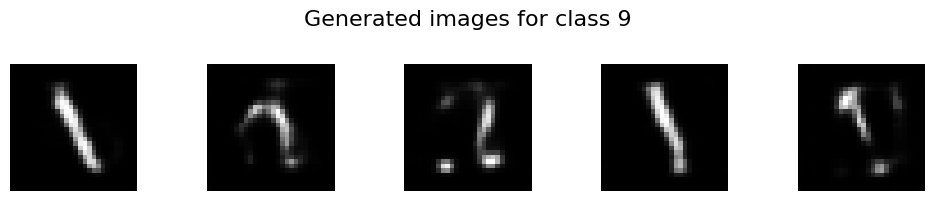

Class 2 loader: 47 batches


100%|██████████| 47/47 [00:01<00:00, 30.08it/s]


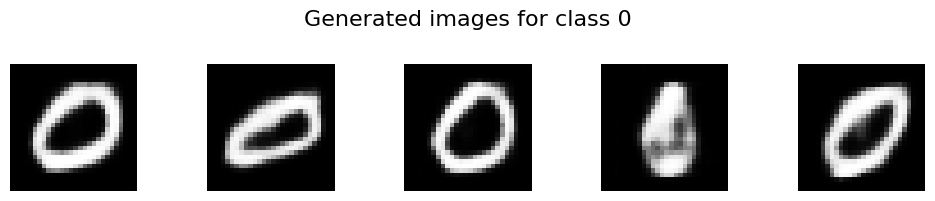

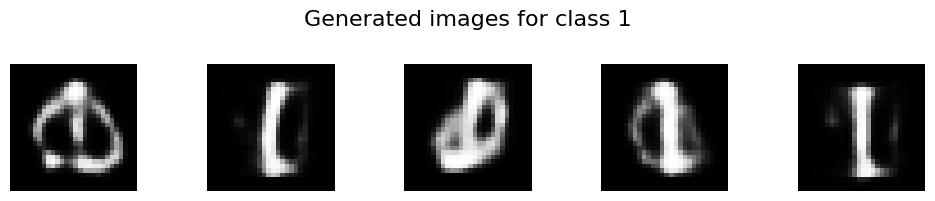

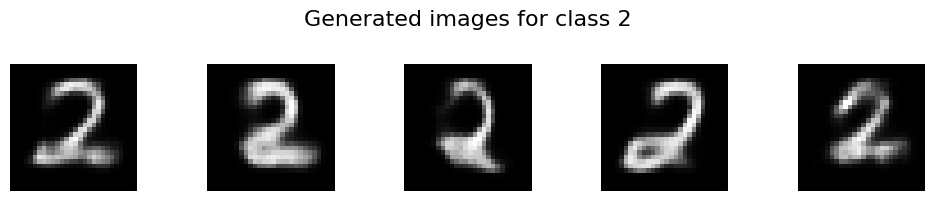

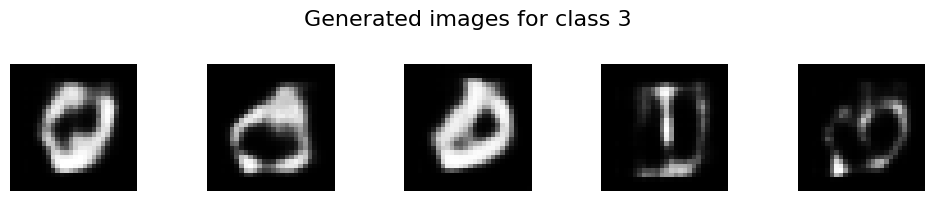

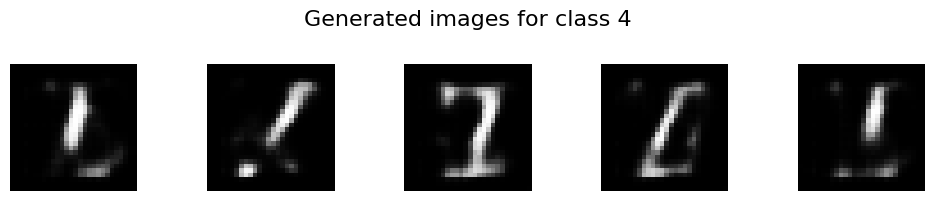

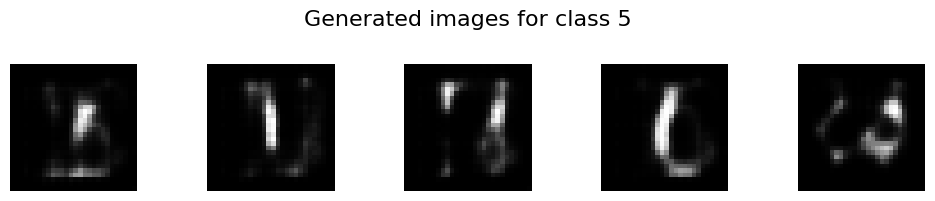

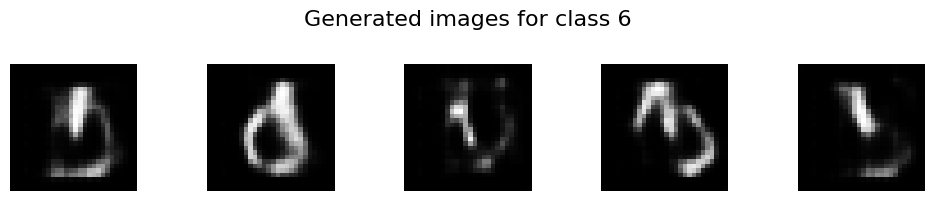

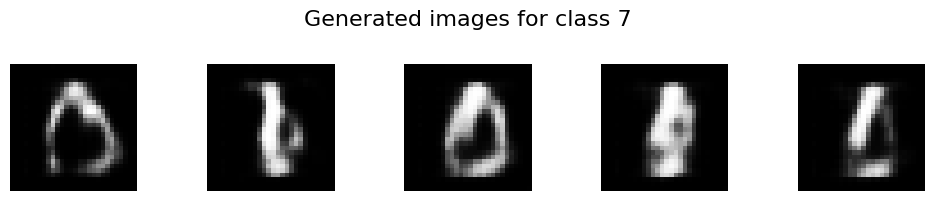

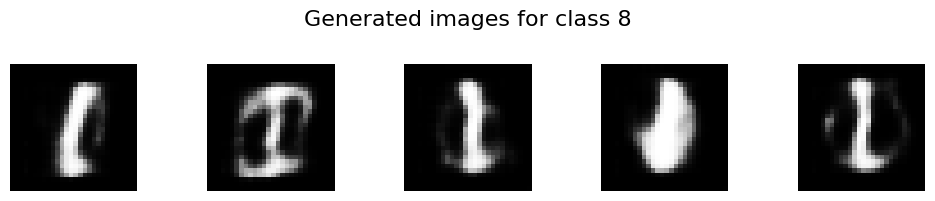

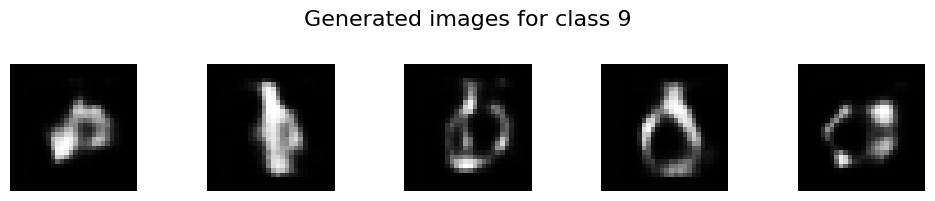

Class 3 loader: 48 batches


100%|██████████| 48/48 [00:01<00:00, 25.00it/s]


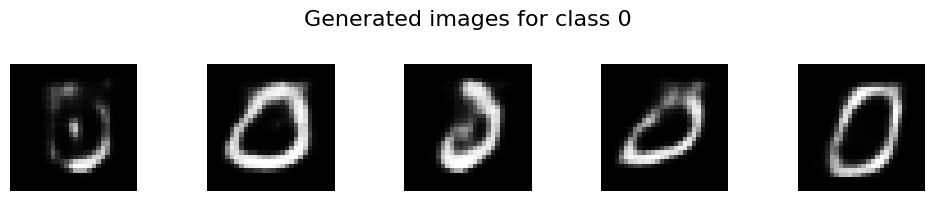

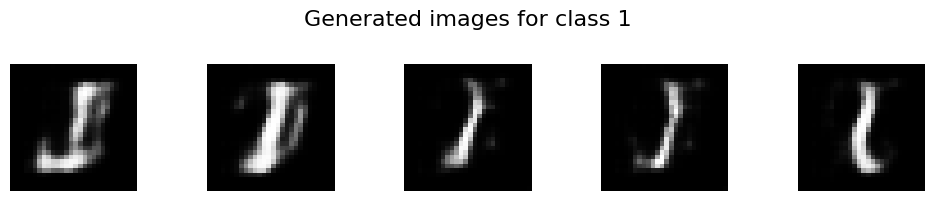

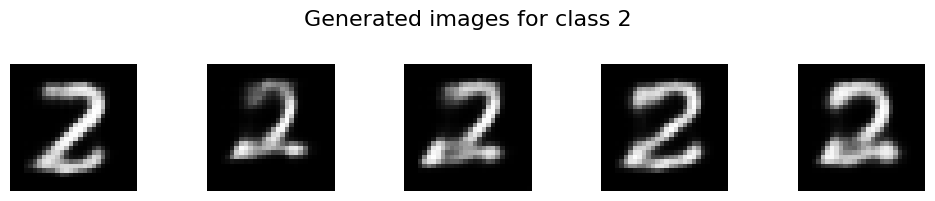

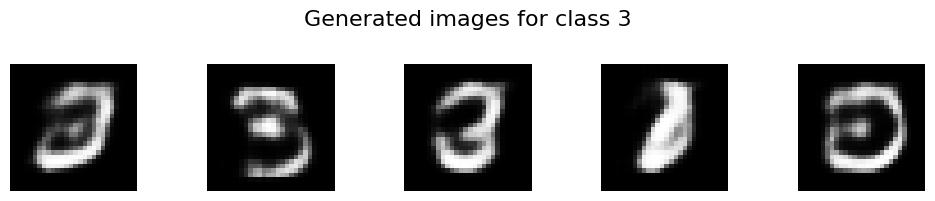

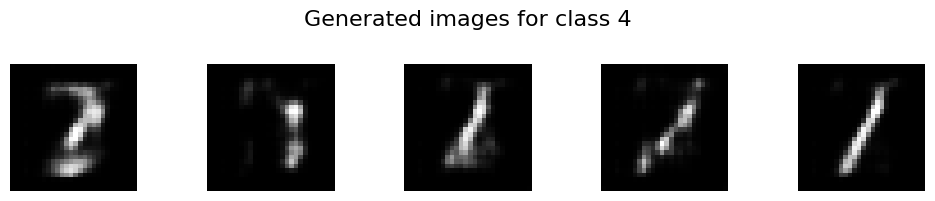

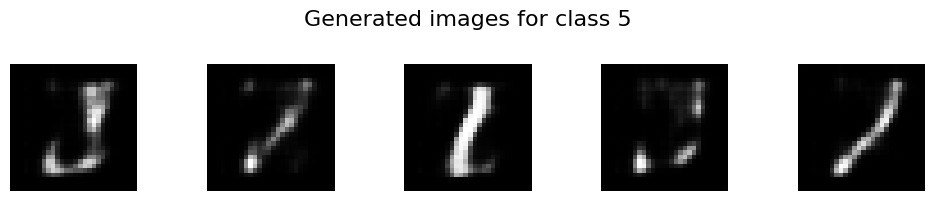

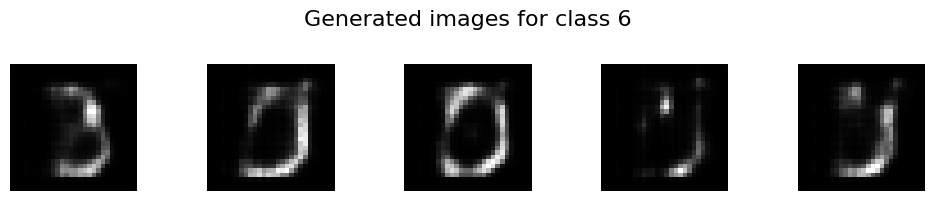

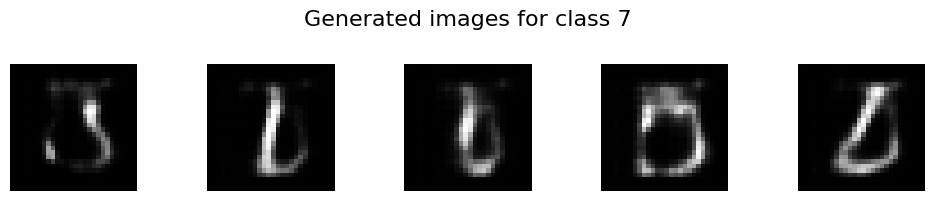

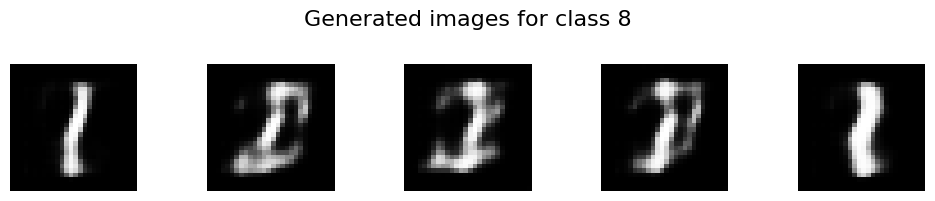

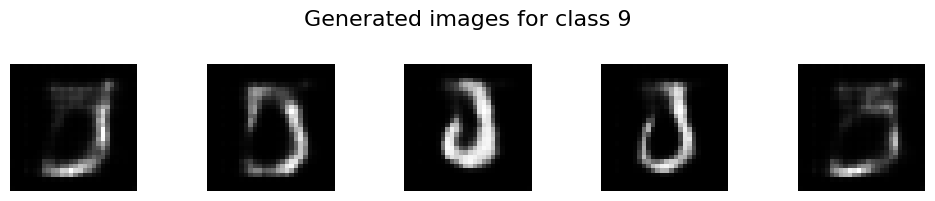

Class 4 loader: 46 batches


100%|██████████| 46/46 [00:02<00:00, 20.64it/s]


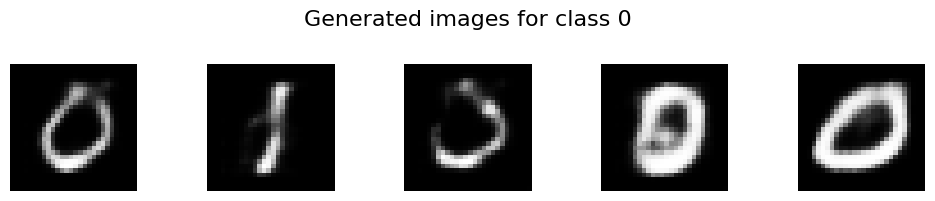

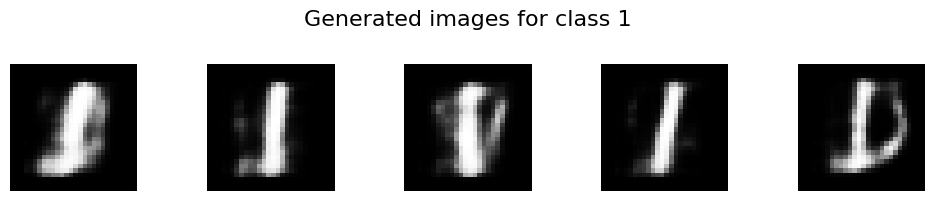

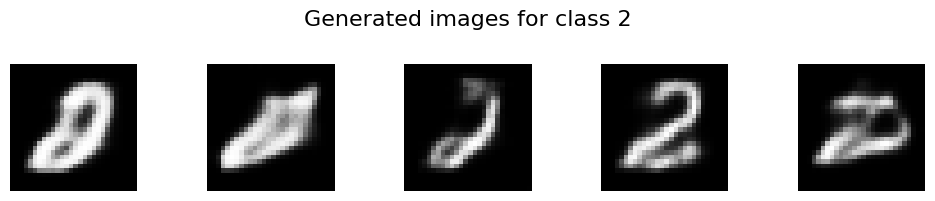

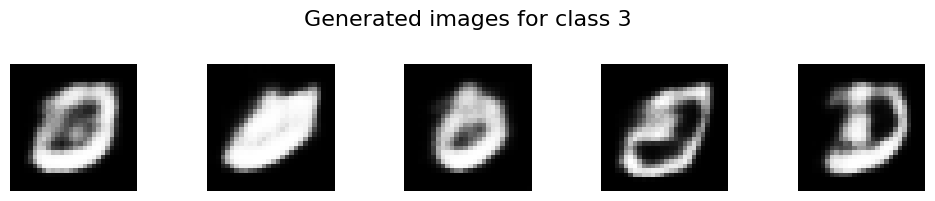

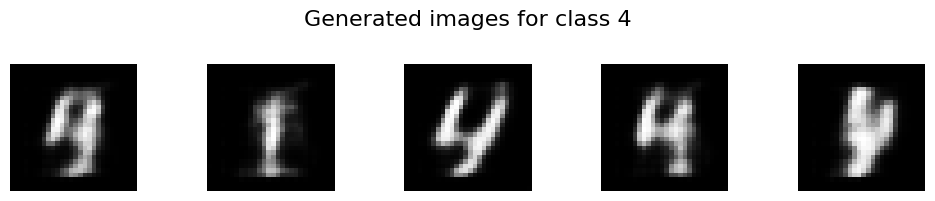

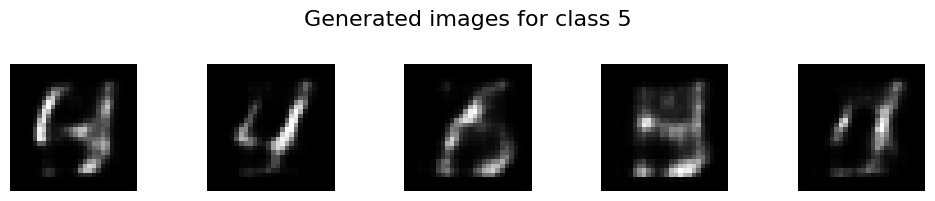

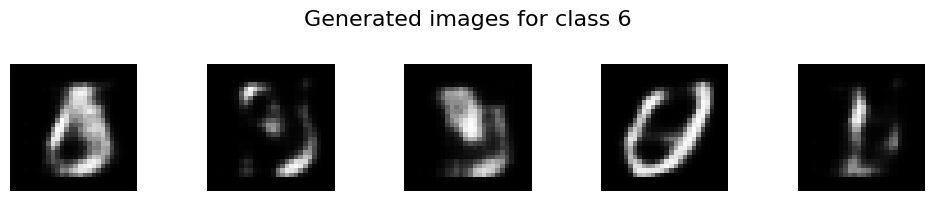

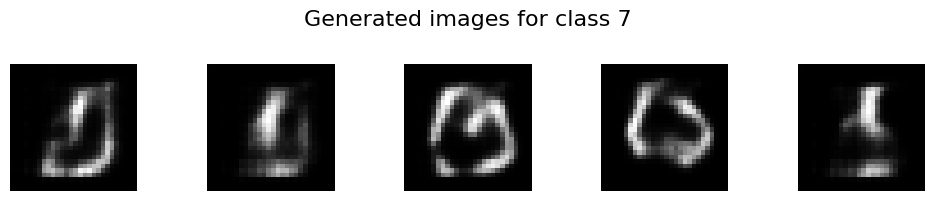

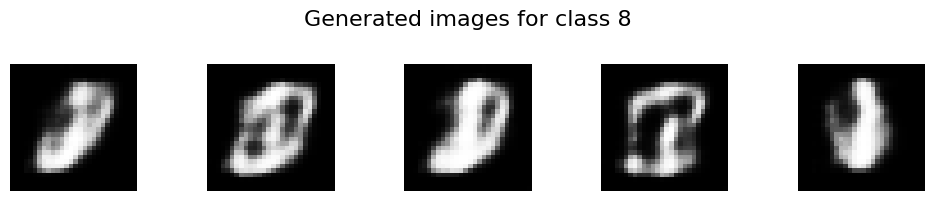

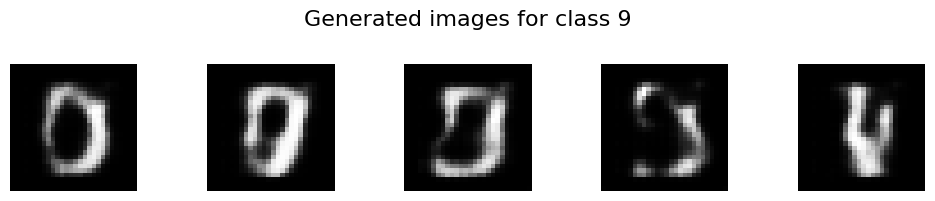

Class 5 loader: 43 batches


100%|██████████| 43/43 [00:02<00:00, 17.40it/s]


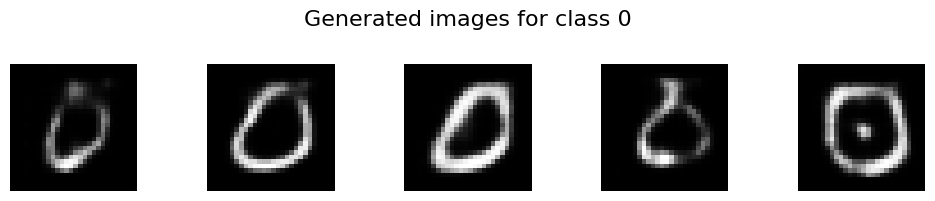

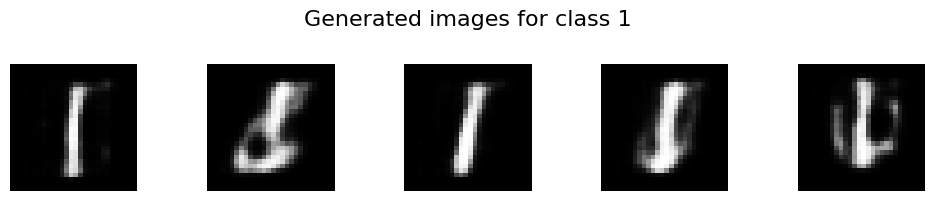

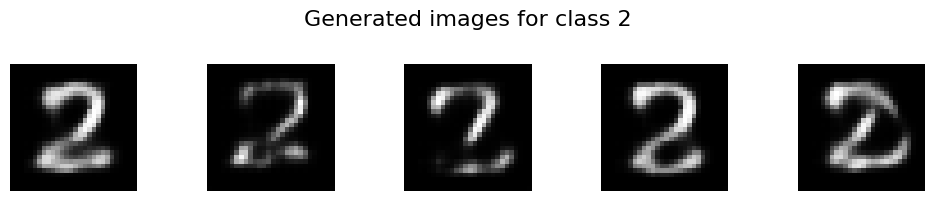

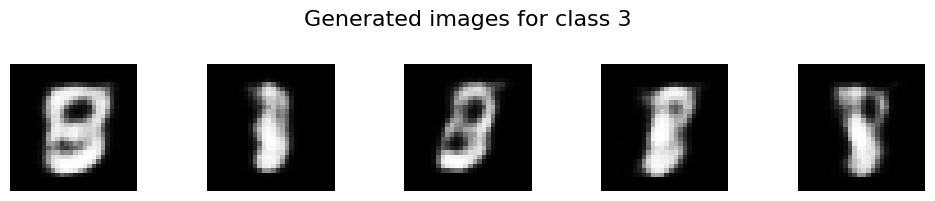

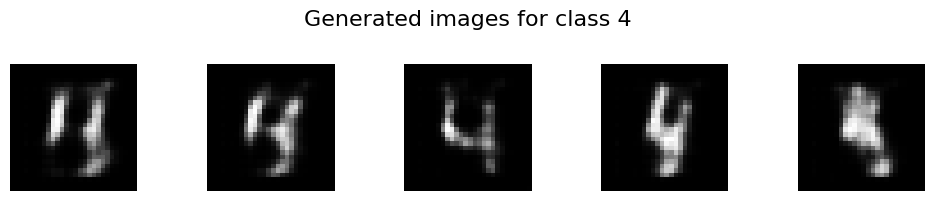

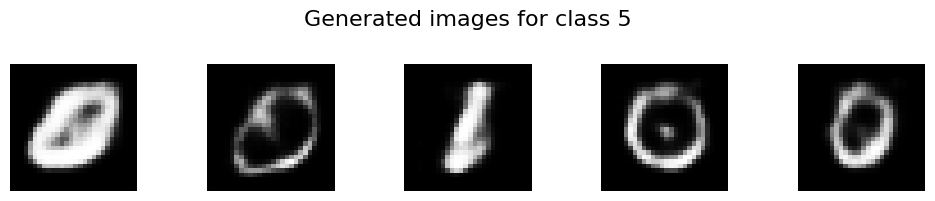

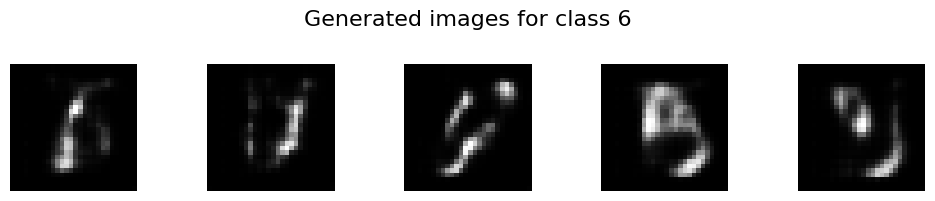

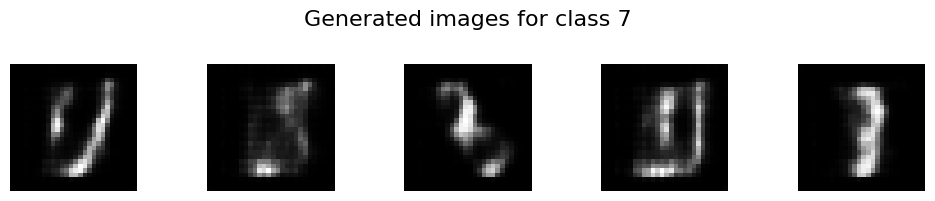

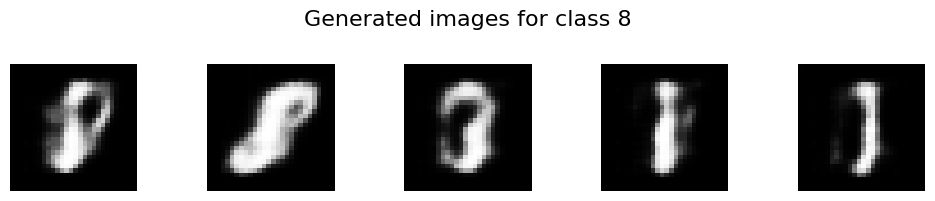

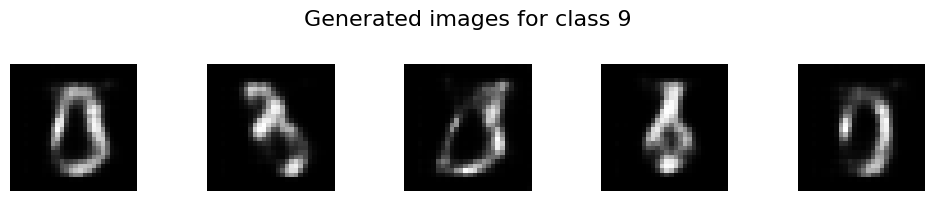

Class 6 loader: 47 batches


100%|██████████| 47/47 [00:02<00:00, 15.86it/s]


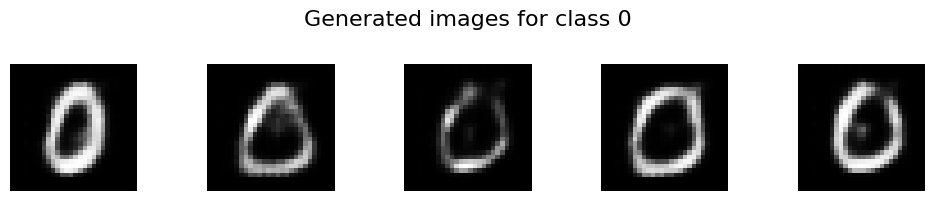

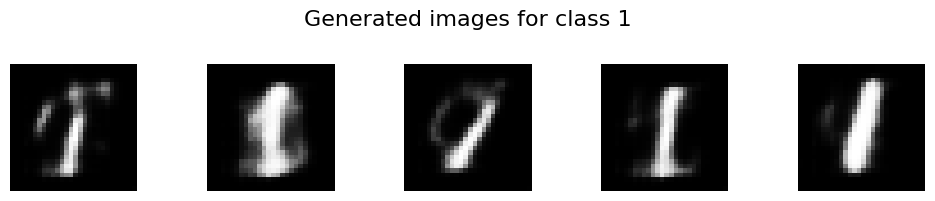

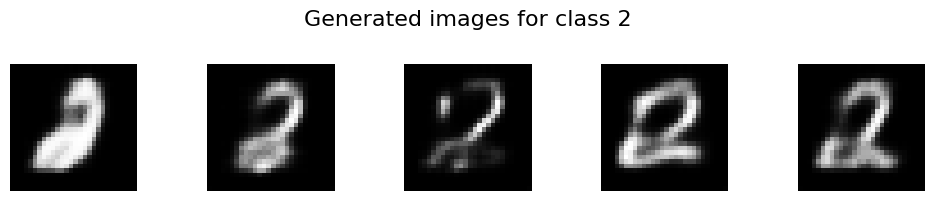

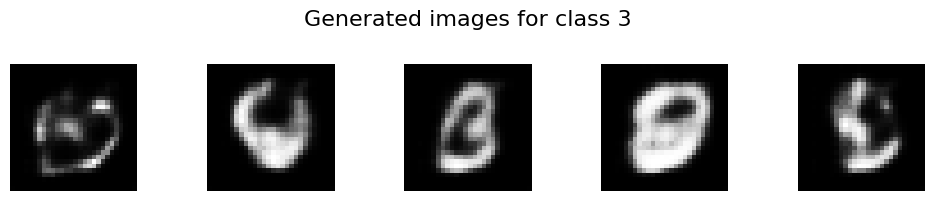

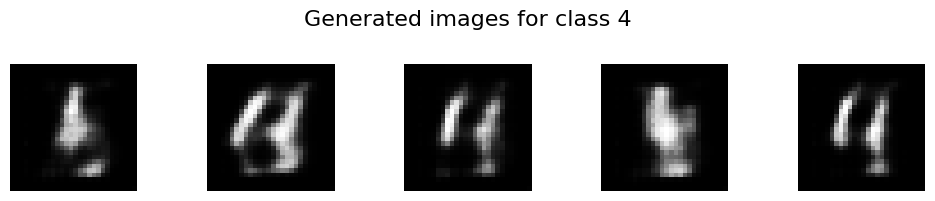

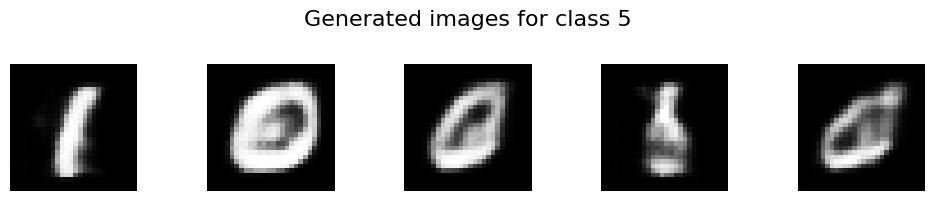

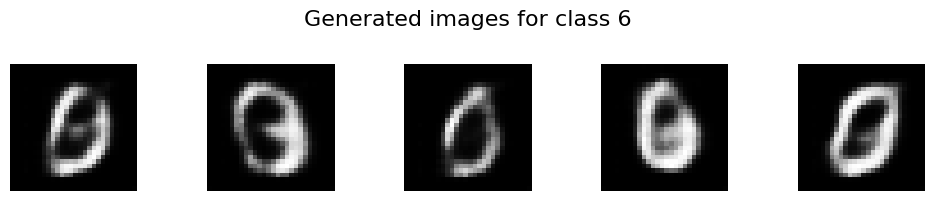

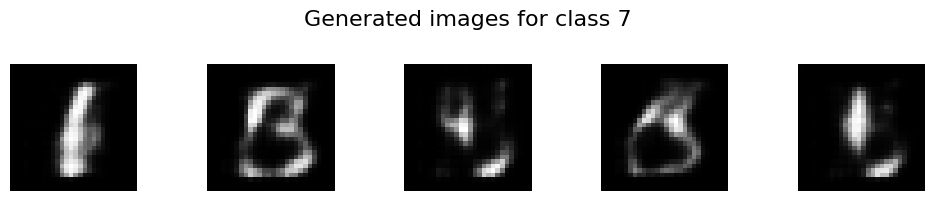

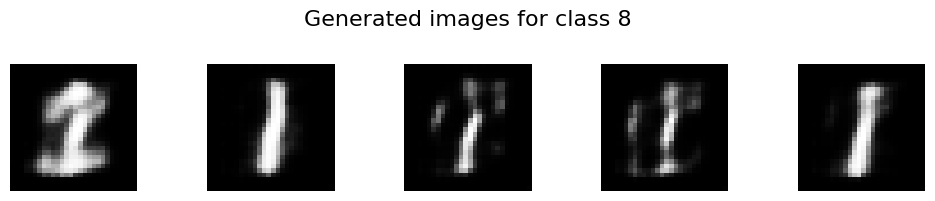

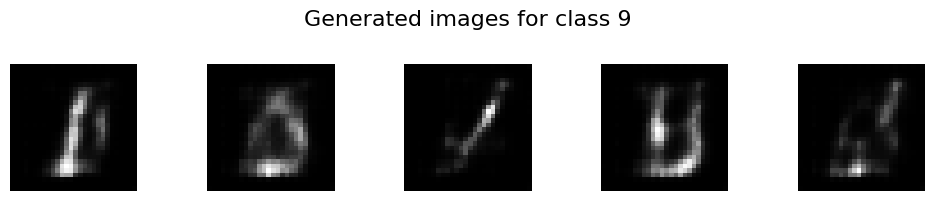

Class 7 loader: 49 batches


100%|██████████| 49/49 [00:03<00:00, 14.40it/s]


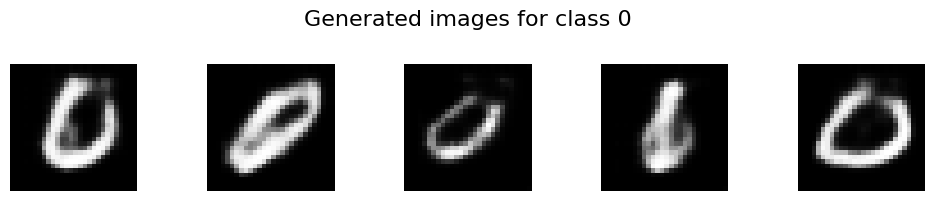

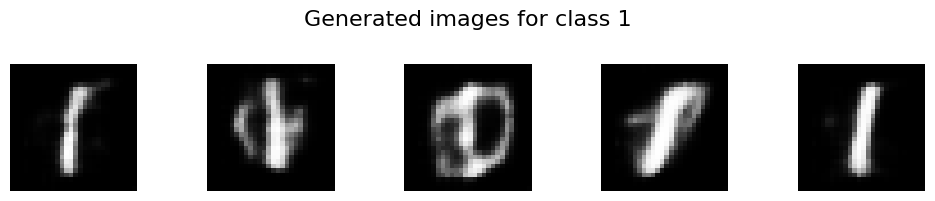

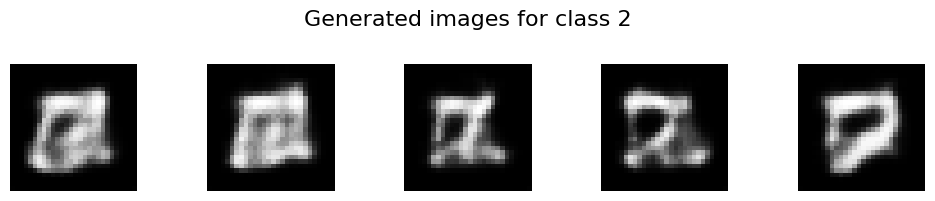

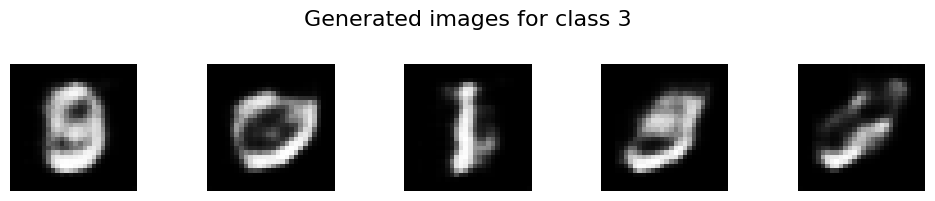

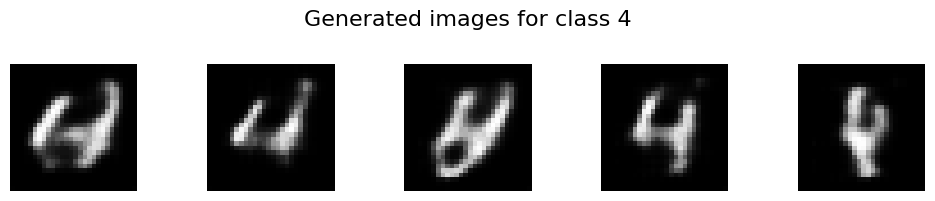

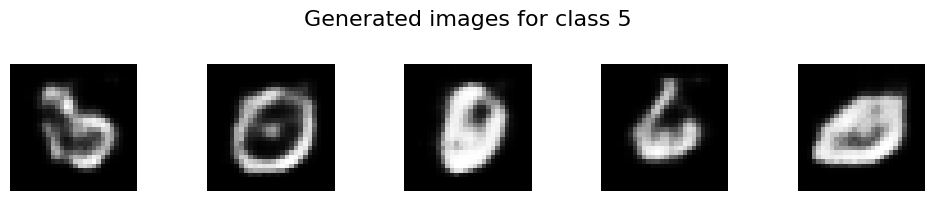

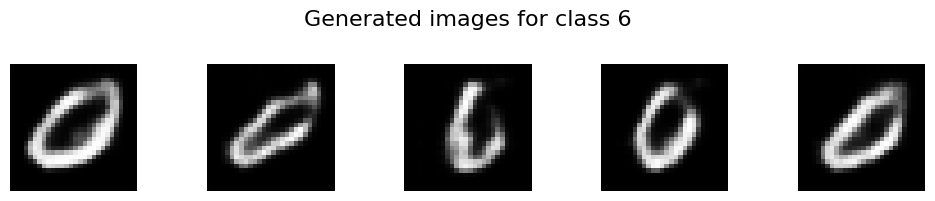

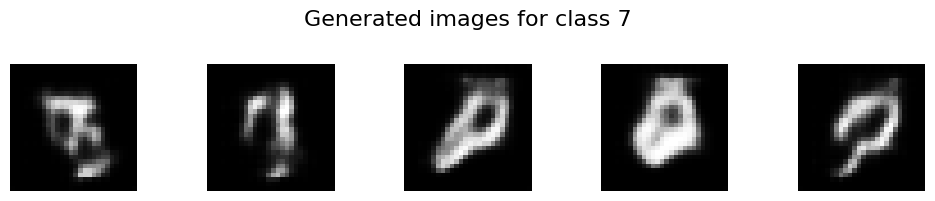

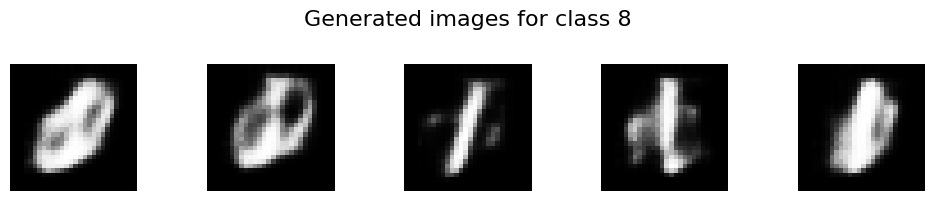

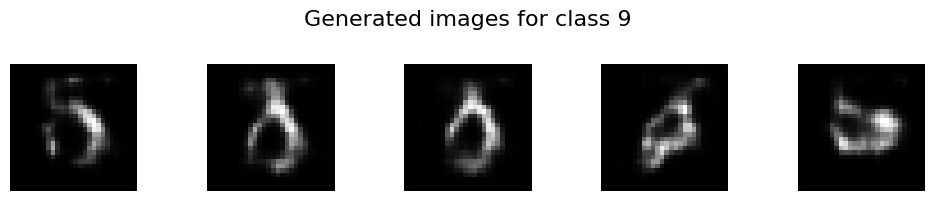

Class 8 loader: 46 batches


100%|██████████| 46/46 [00:03<00:00, 12.41it/s]


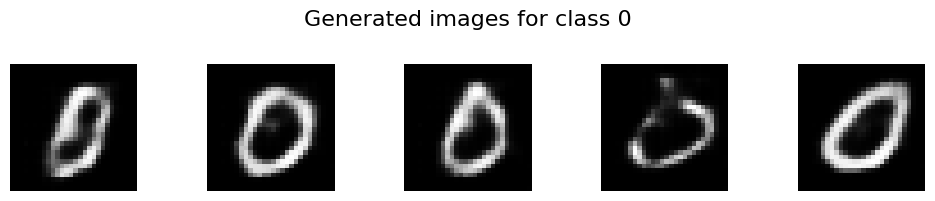

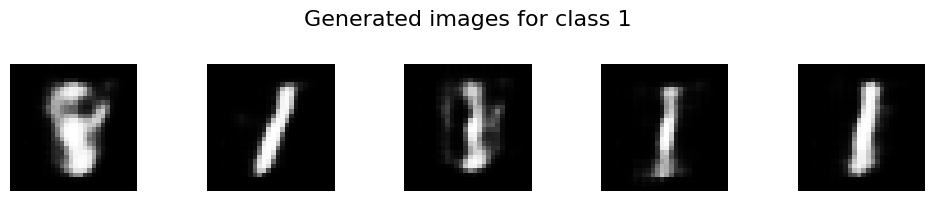

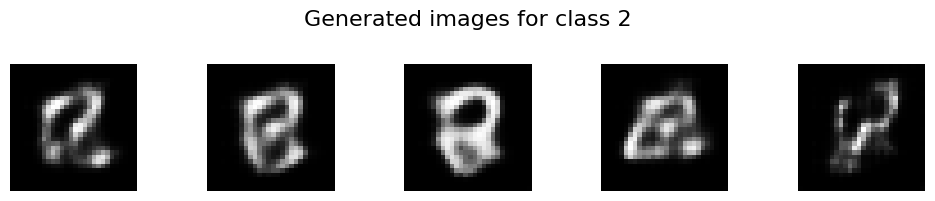

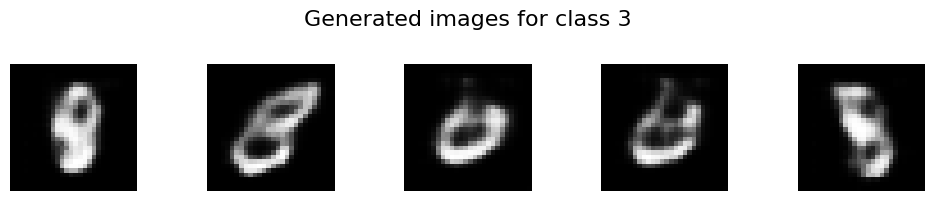

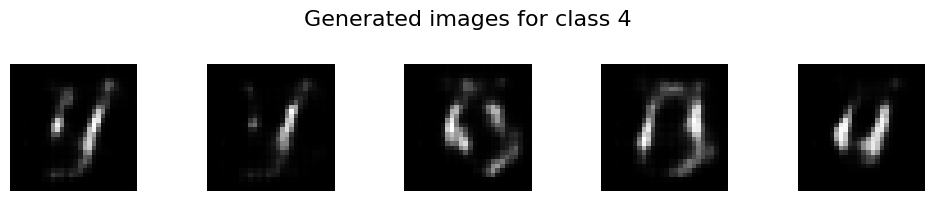

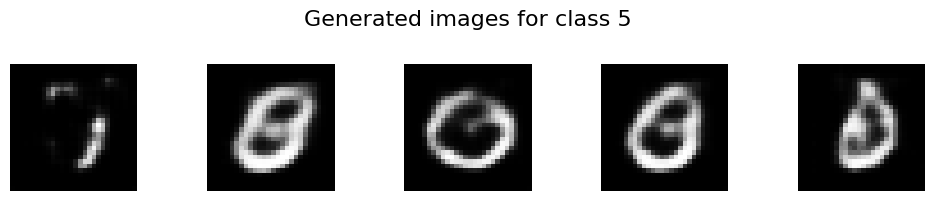

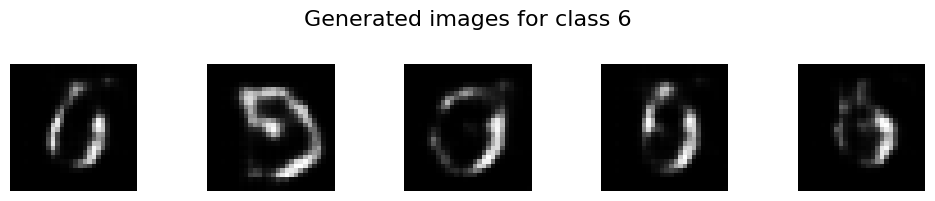

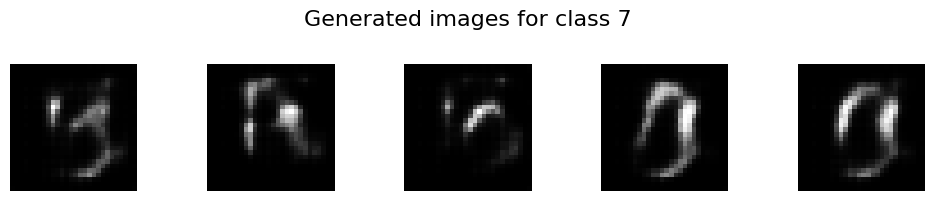

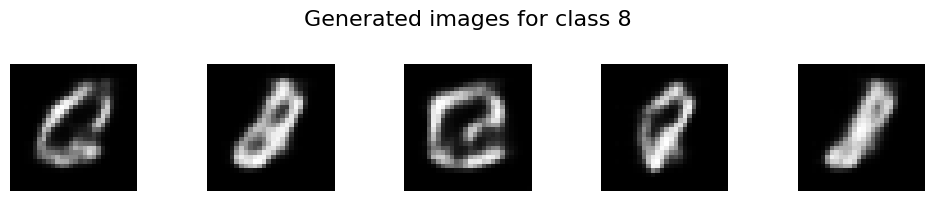

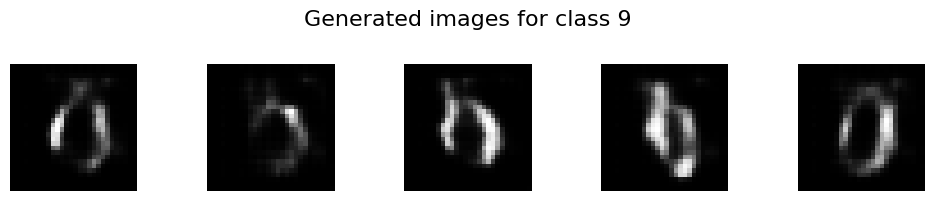

Class 9 loader: 47 batches


100%|██████████| 47/47 [00:04<00:00, 11.48it/s]


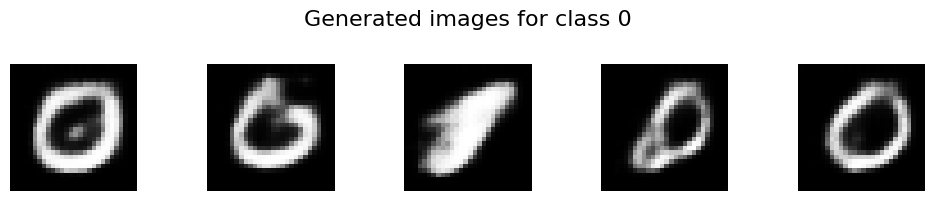

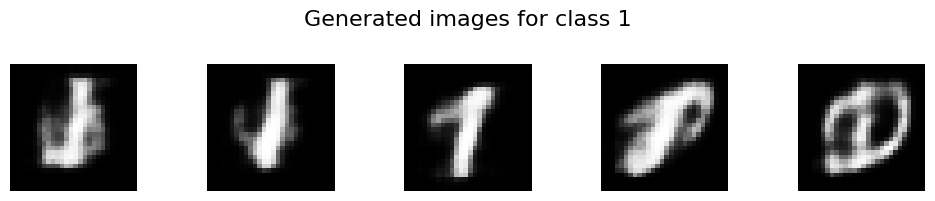

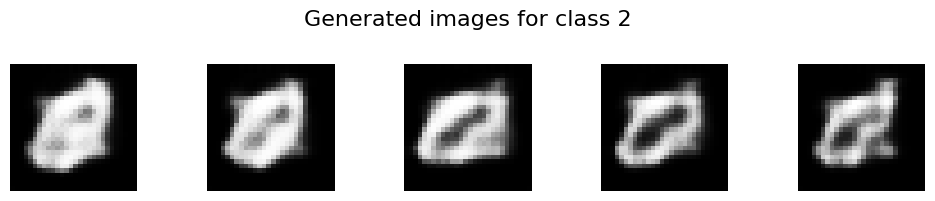

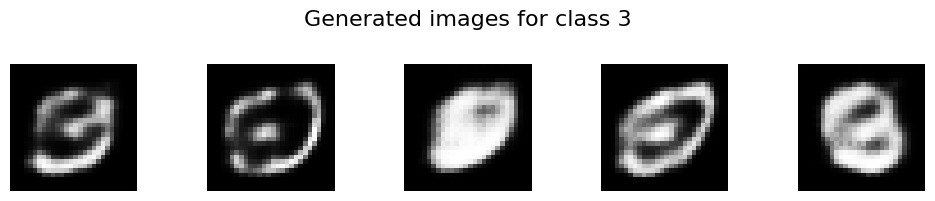

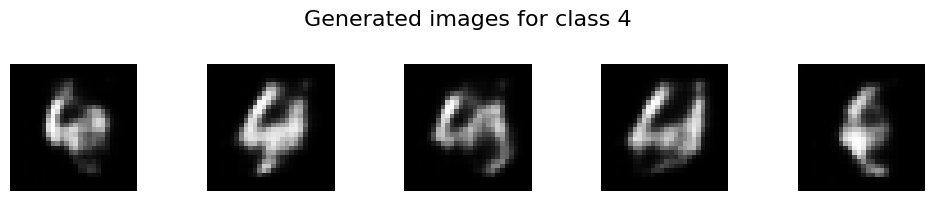

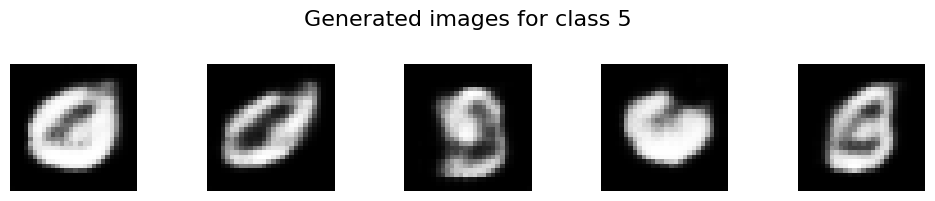

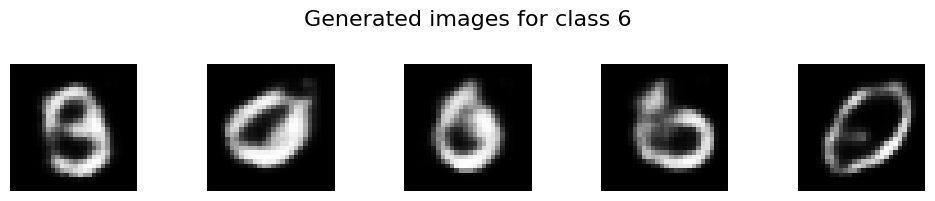

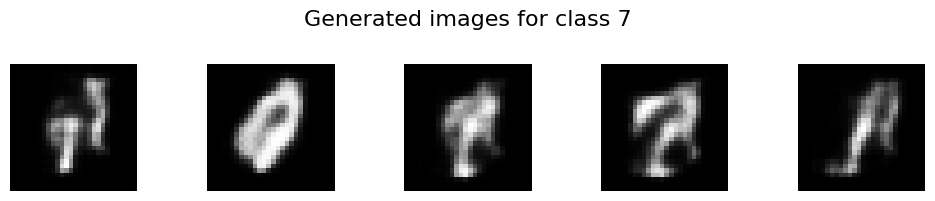

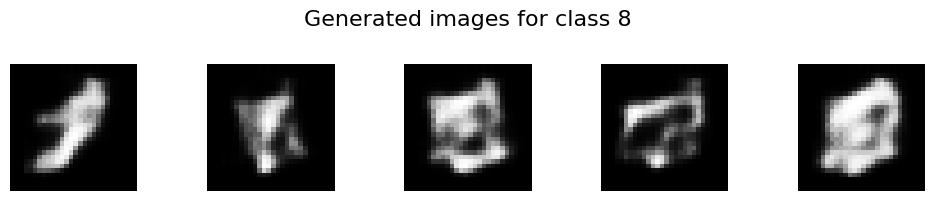

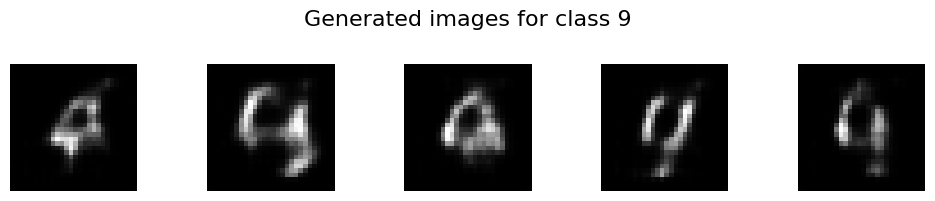

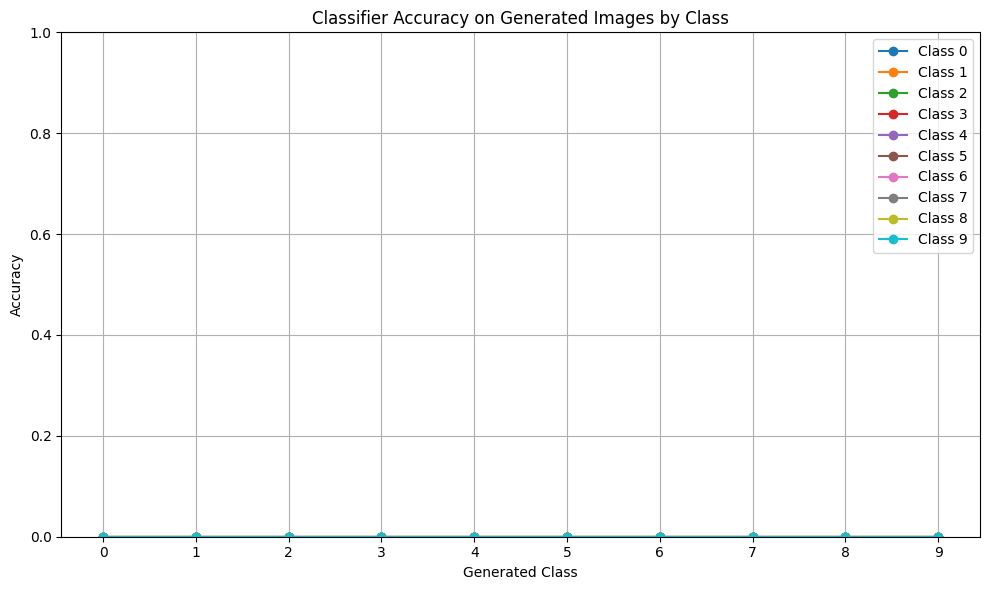

In [ ]:
# test vae
import vae

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = vae.VAE(num_classes=10)
# model = utils.VAE().to(device)
model.to(device)

oprimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
model.train()

num_classes = 10
samples_per_class = 200
accuracies = torch.zeros(num_classes, num_classes)

# fid = FrechetInceptionDistance(feature=64).to(device)
ewc_history = []          # list of EWC objects, one per *finished* class/task

for class_id, loader in cl_train_loaders.items():
    # if class_id > 1:
        # break   # for testing, only train on first 2 classes
    # display reconstructed images
    print(f"Class {class_id} loader: {len(loader)} batches")
    for _ in range(10):
        for images, labels in tqdm(loader):
            images = images.to(device)
            labels = labels.to(device)
            # loss, _ = model(images)
            _, x_reconstructed, mu, logvar = model(images, labels)
            loss = utils.vae_loss(x_reconstructed, images, mu, logvar)

            # print(images.shape, x_reconstructed.shape)
            # # VAE loss
            # rec = F.mse_loss(x_reconstructed, images.view(-1, 28*28), reduction='none').sum(dim=(1, 2, 3))
            # kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
            # # print(f"rec: {rec.mean().item():.4f}, kl: {kl.mean().item():.4f}")
            # loss = torch.mean(rec + kl)

             # ---------- EWC regularisation ----------
            reg_term = torch.zeros(1, device=device)
            if ewc_history:                               # skip for very first task
                reg_term = sum(e.penalty(model) for e in ewc_history)
                loss = loss + reg_term * 1e5  # scale the EWC term
            # loss_total = loss + reg_term * 10

            # if reg_term.item() != 0:
            #     print(f"[class {class_id}] reg = {reg_term.item():.3f}")

            oprimizer.zero_grad()
            loss.backward()
            oprimizer.step()
    
    ewc_history.append(utils.EWC(model, loader, device))
    
    # --- Evaluate generated images ---
    model.eval()
    with torch.no_grad():
        for cid in range(num_classes):
            # a) Generate samples for class cid
            z = torch.randn(samples_per_class, 20, device=device)
            gen_labels = torch.full((samples_per_class,), cid, device=device, dtype=torch.long)
            # gen_labels = None
            gen_imgs = model.decode(z, gen_labels).view(-1, 1, 28, 28)
            # # c) Classify
            # logits = clf(gen_imgs)
            # preds = logits.argmax(dim=1)

            # # d) Compute accuracy
            # acc = (preds == gen_labels).float().mean().item()
            # accuracies[class_id, cid] = acc
            # b) Normalize as for MNIST classifier: mean=0.1307, std=0.3081
            # gen_norm = (gen_imgs - 0.1307) / 0.3081
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))
            fig.suptitle(f"Generated images for class {cid}", fontsize=16)
            for i in range(5):
                ax = axes[i]
                img = gen_imgs[i].squeeze().cpu().numpy()
                ax.imshow(img.reshape(28, 28), cmap='gray')
                # ax.set_title(f"Class {labels[i].item()}")
                ax.axis('off')
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()

    model.train()
# plot accuracies over classes, each line for class_id
plt.figure(figsize=(10, 6))
for class_id in range(num_classes):
    plt.plot(range(num_classes), accuracies[class_id].cpu().numpy(), marker='o', label=f"Class {class_id}")
plt.xlabel("Generated Class")
# y from 0 to 1
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy on Generated Images by Class")
plt.xticks(range(num_classes))
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()








In [56]:
ewc_history[1].F['label_embedding.weight'][0].mean().item()

0.0

100%|██████████| 938/938 [00:07<00:00, 123.08it/s]


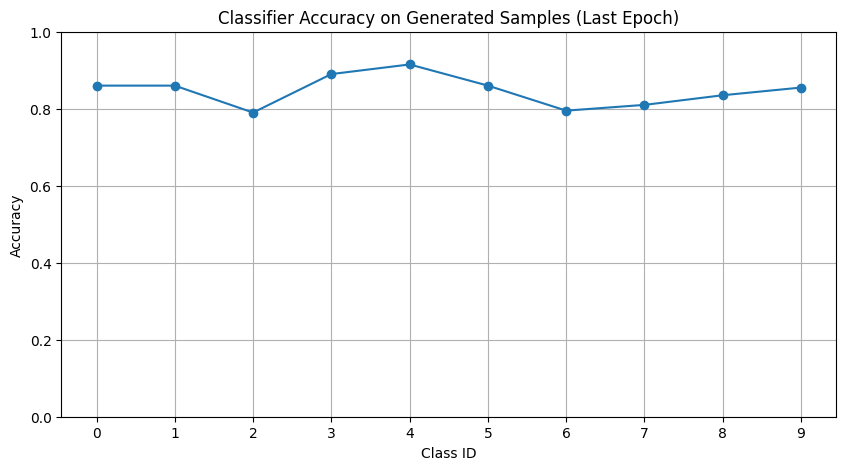

In [34]:
# non-continual learning
# test vae
import vae

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = vae.VAE(num_classes=10)
model.to(device)

oprimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()

num_classes = 10
samples_per_class = 200
accuracies = torch.zeros(20, num_classes)

for epoch in range(20):
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # loss, _ = model(images)
        loss, x_reconstructed, mu, logvar = model(images, labels)
        oprimizer.zero_grad()
        loss.backward()
        oprimizer.step()
    # test conditional generation
     # --- Evaluate generated images ---
    model.eval()
    with torch.no_grad():
        for cid in range(num_classes):
            # a) Generate samples for class cid
            z = torch.randn(samples_per_class, 20, device=device)
            gen_labels = torch.full((samples_per_class,), cid, device=device, dtype=torch.long)
            gen_imgs = model.decode(z, gen_labels).view(-1, 1, 28, 28)

            # b) Normalize as for MNIST classifier: mean=0.1307, std=0.3081
            # gen_norm = (gen_imgs - 0.1307) / 0.3081
            # c) Classify
            logits = clf(gen_imgs)
            preds = logits.argmax(dim=1)
            # print(preds, gen_labels)

            # plot generated images
            # fig, axes = plt.subplots(2, 5, figsize=(10, 5))
            # fig.suptitle(f"Generated images for class {cid}", fontsize=16)
            # for i in range(10):
            #     ax = axes[i // 5, i % 5]
            #     img = gen_imgs[i].squeeze().cpu().numpy()
            #     ax.imshow(img.reshape(28, 28), cmap='gray')
            #     ax.set_title(f"Class {labels[i].item()}")
            #     ax.axis('off')
            # plt.tight_layout(rect=[0, 0, 1, 0.96])
            # plt.show()
            # break

            # d) Compute accuracy
            acc = (preds == gen_labels).float().mean().item()
            # print(f"Accuracy for class {cid}: {acc:.4f}")
            # print(f"Epoch {epoch+1}, Class {cid}, Accuracy: {acc:.4f}")
            accuracies[epoch, cid] = acc
            # break
    model.train()

# plot accuracies in the last epoch
plt.figure(figsize=(10, 5))
plt.plot(accuracies[-1].cpu().numpy(), marker='o')
plt.xticks(range(num_classes), range(num_classes))
# y from 0 to 1
plt.ylim(0, 1)
plt.xlabel("Class ID")
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy on Generated Samples (Last Epoch)")
plt.grid()
plt.show()

    # with torch.no_grad():
    #     model.eval()
    #     # generate images for class_id
    #     z = torch.randn(10, 20).to(device)
    #     labels = torch.tensor(torch.arange(10)).to(device)
    #     generated_images = model.decode(z, labels)
    #     generated_images = generated_images.cpu().numpy()
    #     # plot generated images
    #     fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    #     fig.suptitle(f"Generated images for class {class_id}", fontsize=16)
    #     for i in range(10):
    #         ax = axes[i // 5, i % 5]
    #         img = generated_images[i].squeeze()
    #         ax.imshow(img.reshape(28, 28), cmap='gray')
    #         ax.set_title(f"Class {labels[i].item()}")
    #         ax.axis('off')
    #     plt.tight_layout(rect=[0, 0, 1, 0.96])
    #     plt.show()



In [26]:
accuracies

tensor([[0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.6000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0